In [ ]:
import numpy as np
import timeit
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipywidgets import interact, Button, fixed
from sklearn.datasets import fetch_openml

# **Principal Component Analysis**
We will implement the *principal component analysis* (PCA) algorithm in two versions. First, we will implement the standard version for non high-dimensional data. Subsequently, we will implement the version suited for high dimensional data and compare both versions regarding their computational complexity.

### **Data Sets** <a class="anchor" id="data-sets"></a>

In this notebook, we will consider two kinds of data sets:
- a two-dimensional toy data set to illustrate eigenvectors
- and the image data set [MNIST](https://www.openml.org/d/554) containing images of hand-written digits.

Mathematically, we denote an obtained data set consisting of $N$ samples as a matrix $\mathbf{X} \in \mathbb{R}^{N \times D}$, where the $n$-th row of this matrix represents the $n$-th samples being a $D$-dimensional feature vector: $\mathbf{x}_n = (x_{n1}, \dots, x_{nD})^\mathrm{T}$.

Below, we generate the toy data set, download the image data set, and visualize both.

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


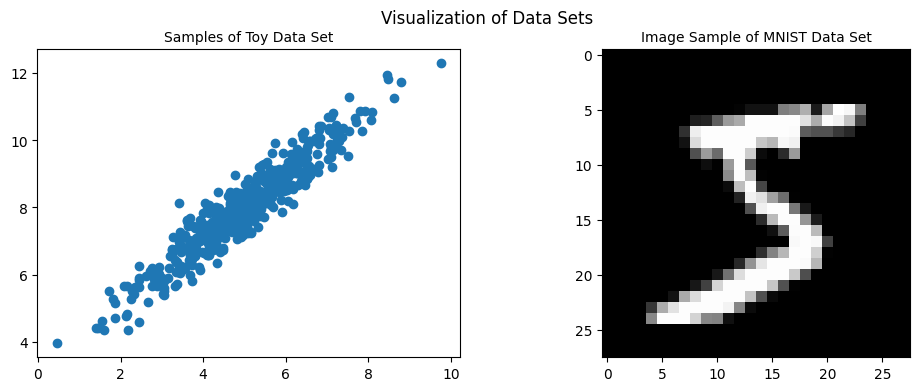

In [ ]:
# Generate toy data set.
X_toy = np.random.RandomState(42).multivariate_normal(mean=[5, 8], cov=[[2, 1.9], [1.9, 2]], size=500)

# Download MNIST data set.
X_img, y_img = fetch_openml('mnist_784', version=1, return_X_y=True)
X_img = X_img.values
y_img = y_img.values

# Plot data sets.
fig = plt.figure(figsize=(12, 4))
fig.suptitle('Visualization of Data Sets')
plt.subplot(121)
plt.title('Samples of Toy Data Set', fontsize=10)
plt.scatter(X_toy[:, 0], X_toy[:, 1])
plt.subplot(122)
plt.title('Image Sample of MNIST Data Set', fontsize=10)
plt.imshow(X_img[0].reshape(28, 28), cmap='gray')
plt.show()

### **Standardization** <a class="anchor" id="standardization"></a>

Before we implement PCA, we will need to standardize the data sets. The feature value $x_{*d}$ of a sample $\mathbf{x}_*$ can be standardized according to
t the samples will have zero mean and one varia\begin{equation}
    x_{*d} \leftarrow \frac{x_{*d} - \mu_d}{\sigma_d},
\end{equation}
where $\mu_d \in \mathbb{R}$ denotes the mean and $\sigma_d \in \mathbb{R}_{>0}$ the standard deviation of the $d$-th feature. Both are usually computed on a training data set $\mathbf{X}$.
The standardization ensures that the samples will have zero mean and one variance. It also known as
[data normalization or feature scaling](https://en.wikipedia.org/wiki/Feature_scaling).

> A corresponding class for standardization is to be implemented below.

In [ ]:
class StandardScaler:
    """Standardize features by removing the mean and scaling to unit variance."""

    def fit(self, X):
        """Determine required parameters to standardize data.

        Args:
            X (array-like): Input samples

        Returns:
            The fitted StandardScaler object.
        """
        # Transform to ndarray.
        X = np.array(X)
        # Compute the mean value for each feature in the training set.
        self.mu_ = np.mean(X, axis=0)
        # Compute the standard deviation for each feature in the training set.
        self.sigma_ = np.std(X, axis=0)
        return self

    def transform(self, X):
        """Standardizes input samples `X`.

        Args:
            X (array-like): Input samples.

        Returns:
            Standardized samples.
        """
        # Transform to ndarray.
        X = np.array(X)
        # Standardize data.
        Z = (X - self.mu_) / (self.sigma_+1e-10)
        return Z

    def inverse_transform(self, Z):
        """Scales back the data to the original data representation.

        Args:
            Z (array-like): Standardized samples.

        Returns:
            Re-scaled samples.
        """
        # Transform to ndarray.
        Z = np.array(Z)
        # Re-scale samples to original space.
        X = Z*self.sigma_ + self.mu_ # <-- SOLUTION
        return X

> Standardize both data sets and visualize the results.

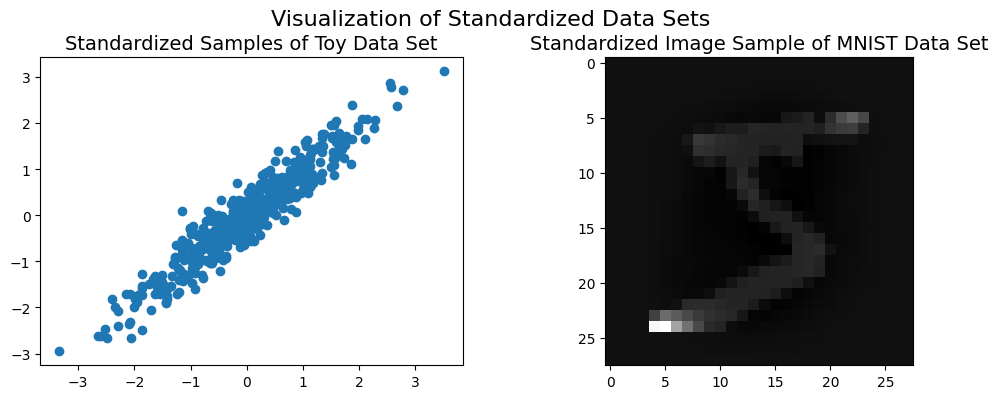

In [ ]:
# Fit StandardScaler on the toy data set.
scaler_toy = StandardScaler().fit(X_toy) # <-- SOLUTION

# Use scaler to standardize the toy data set.
X_toy_std = scaler_toy.fit(X_toy).transform(X_toy) # <-- SOLUTION

# Fit StandardScaler on the MNIST data set.
scaler_img = StandardScaler().fit(X_img) # <-- SOLUTION

# Fit StandardScaler on the MNIST data set.
X_img_std = scaler_img.transform(X_img) # <-- SOLUTION

# Plot data sets.
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Visualization of Standardized Data Sets', fontsize=16, y=1)
ax[0].scatter(X_toy_std[:, 0], X_toy_std[:, 1])
ax[0].set_title('Standardized Samples of Toy Data Set', fontsize=14)
ax[1].imshow(X_img_std[0].reshape(28, 28), cmap='gray')
ax[1].set_title('Standardized Image Sample of MNIST Data Set', fontsize=14)
plt.show()

#### **Question:**
Why should we standardize data before applying PCA?

   Standardization is a advisable method for PCA, especially when the features in the original dataset are measured on significantly different scales. For example, there are two features with different units, i.e., one is in km and another one in cm, but both have the identical relative change in their values. The feature measured in km will reflect a minor absolute change compared to the one measured in cm. In this case, if we do not standardize the feature, PCA will give higher preference to the feature measured in cm.

### **PCA on Toy Data Set** <a class="anchor" id="pca-on-toy-data-set"></a>

Now we will implement PCA given a training set $\mathbf{X}$ with mean $\boldsymbol{\mu} \in \mathbb{R}^D$ (being $\mathbf{0}$ if $\mathbf{X}$ has been standardized) to transform samples from the $D$-dimensional space into an $M \leq D$ dimensional space.
We then need to perform the following steps.

> A corresponding class for the PCA is to be implemented below.

   
A common way to determine the number of principal components $M$ is to define a threshold $c \in (0, 1]$ for the **explained variance** such that
\begin{equation}
M_c = \text{arg min}_{M \in \{1, \dots, D\}} M \quad \text{ s.t. } \quad \frac{\sum_{j=1}^{M} \lambda_{i_j}}{\sum_{i=l}^{D} \lambda_{l}} \geq c.
\end{equation}

> Determine the number of components based on explained variance if `n_components` is in the intervall $(0, 1]$.

In [ ]:
class PCA:
    """This class implements the principal component analysis for N >= D,
        where N is the number of samples and D is the number of features.

    Args:
        n_comonents (int, float): If `n_components` is an integer, the number of dimension will be reduced
            from D to `n_components`. If `0 < n_components < 1`,  select the number
            of components such that the amount of variance that needs to be explained
            is greater or equal than the percentage specified by `n_components`.

    """
    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        """Determine required parameters of the PCA.

        Args:
            X (array-like): Input samples.

        Returns:
            The fitted PCA object.
        """
        # Transform to ndarray.
        X = np.array(X)

        # Number of samples and features
        N, D = X.shape

        # Compute mean of each feature, which is zero
        # if samples have been standardized.
        self.mu_ = np.mean(X, axis=0)

        # Compute DxD covariance matrix (take mean into account).
        S = ((X-self.mu_).T @ (X-self.mu_)) / N

        # Compute eigenvalues and eigenvectors.
        self.lmbdas_, self.U_ = np.linalg.eigh(S)

        # Sort eigenvalues and eigenvectors in decreasing order.
        sort_idx = np.argsort(-self.lmbdas_)
        self.lmbdas_ = self.lmbdas_[sort_idx]
        self.U_ = self.U_[:, sort_idx]

        # Determine number of selected components.
        self._determine_M()

        return self

    def transform(self, X):
        """ Transforms samples from the D-dimensional input space into
            the M-dimensional projection space.

        Args:
            X (ndarray): Samples in the input space.

        Returns
            Transformed samples in the projection space.
        """
        B = self.U_[:, :self.M_]
        X = np.array(X)
        Z = (X-self.mu_) @ B
        return Z

    def inverse_transform(self, Z):
        """ Retransforms samples from the M-dimensional projection space into
            the D-dimensional input space.

        Args:
            Z (array-like): Samples in the projection space.

        Returns:
            Re-transformed samples in the input space.
        """
        B = self.U_[:, :self.M_]
        Z = np.array(Z)
        X = Z @ B.T
        X += self.mu_
        return X

    def _determine_M(self):
        """Determine number of finally selected components."""
        if self.n_components >= 1:
            # If `n_components` is an integer, the number of dimension will be reduced
            # from D to `n_components`.
            self.M_ = self.n_components
        elif 0 < self.n_components < 1:
            # If `0 < n_components < 1`,  select the number of components such that the
            # amount of variance that needs to be explained is greater or equal than the
            # percentage specified by `n_components` (corresponds to c in the introductory
            # formulas).
            cum_lmbdas = np.cumsum(self.lmbdas_ / np.sum(self.lmbdas_))
            self.M_ = np.argmax(cum_lmbdas >= self.n_components) + 1
        else:
            raise ValueError('Invalid `n_components` parameter.')

> Having implemented the PCA, we apply it to the two-dimensional toy data set to visualize eigenvectors and eigenvalues.

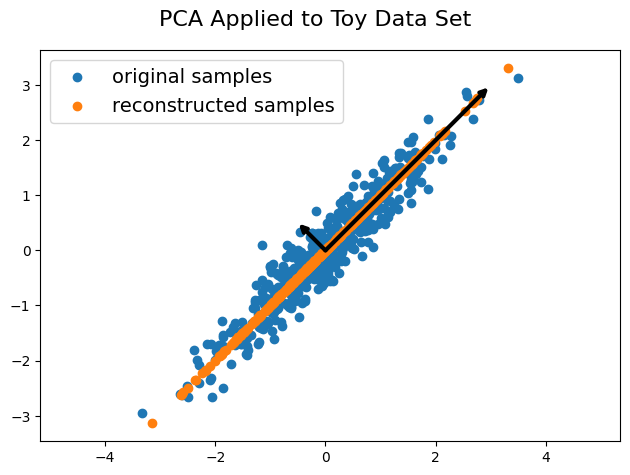

In [ ]:
# Fit PCA object with M=1.
pca = PCA(n_components=1).fit(X_toy_std) # <-- SOLUTION

# Transform samples of standardized toy data set.
Z = pca.transform(X_toy_std) # <-- SOLUTION

# Reconstruct original samples from transformed samples.
X_rec = pca.inverse_transform(Z) # <-- SOLUTION

# Visualize results of PCA.
plt.figure()
plt.suptitle("PCA Applied to Toy Data Set", fontsize=16)
plt.scatter(X_toy_std[:, 0], X_toy_std[:, 1], label='original samples')
plt.scatter(X_rec[:, 0], X_rec[:, 1], label='reconstructed samples')
for lmbda, u in zip(pca.lmbdas_, pca.U_.T):
    u = u * 3 * np.sqrt(lmbda)
    plt.annotate('', pca.mu_ + u, pca.mu_,
                 arrowprops=dict(arrowstyle='->', linewidth=3, shrinkA=0, shrinkB=0))
plt.axis('equal')
plt.legend(prop={'size': 14})
plt.tight_layout()
plt.show()

### **PCA on Image Data Set** <a class="anchor" id="pca-on-image-data-set"></a>

In this section, we will analyze the performance of the PCA on the image data set MNIST. Therefor, we analyze how the number of selected principal components $M$ affects our reconstruction error be.
> Implement a function for computing the reconstruction error (i.e., mean squared error):
\begin{equation}
J = \frac{1}{N} \sum_{n=1}^{N} ||\mathbf{x}_n - \tilde{\mathbf{x}}_{n}||^2.
\end{equation}

In [ ]:
def compute_reconstruction_error(X_orig, X_rec):
    """Computes the reconstruction error, i.e., mean squared error.

    Args:
        X_orig (array-like): Original samples.
        X_rec (array-like): Reconstructed samples.

    Returns:
        Reconstruction error.
    """
    return np.square(np.subtract(X_orig, X_rec)).sum(axis=1).mean()

> Compute the error in dependence of the number of selected components $M$.

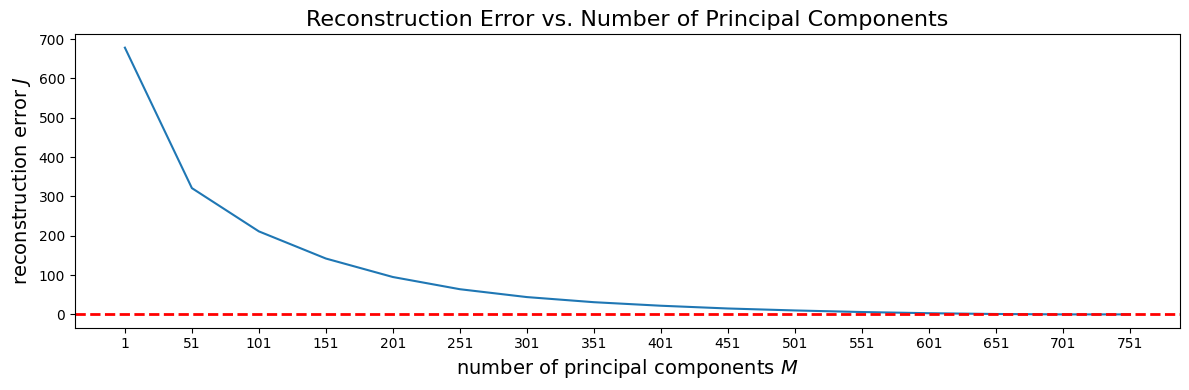

In [ ]:
# Create list of M values.
M_list = np.arange(1, np.size(X_img, axis=1)+1, 50)

# Iterate over different numbers of principal components M compute the
# reconstruction error J.
J_list = np.empty_like(M_list) # <-- SOLUTION
for i, M in enumerate(M_list): # <-- SOLUTION
    pca = PCA(n_components=M).fit(X_img_std) # <-- SOLUTION
    X_img_rec = pca.inverse_transform(pca.transform(X_img_std)) # <-- SOLUTION
    J_list[i] = compute_reconstruction_error(X_orig=X_img_std, X_rec=X_img_rec) # <-- SOLUTION

# Plot reconstruction error.
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(M_list, J_list)
ax.xaxis.set_ticks(M_list)
ax.axhline(xmin=0, xmax=1, linestyle='--', color='r', linewidth=2)
ax.set_xlabel('number of principal components $M$', fontsize=14)
ax.set_ylabel('reconstruction error $J$', fontsize=14)
ax.set_title('Reconstruction Error vs. Number of Principal Components', fontsize=16)
plt.tight_layout()
plt.show()

> Finally, show the qualitative performance of the PCA through visual inspections of examples for different values of the explained variance.

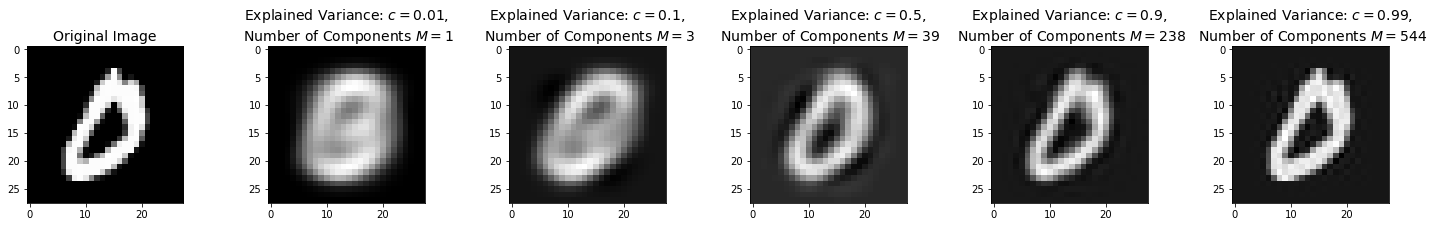

In [ ]:
@interact(image_idx=(0, len(X_img_std)-1), x0=fixed(28), x1=fixed(28), X=fixed(X_img_std), scaler=fixed(scaler_img))
def show_explained_variance_reconst(image_idx, x0, x1, X, scaler):
    """
    Shows the reconstruction of image `X[image_idx]` for different values `c` of explained
    variances.

    Parameters
    ----------
    image_idx : int
        Index of image to be reconstructed.
    x0 : int
        Number of pixels in first dimension.
    x1 : int
        Number of pixels in second dimension.
    X : array-like, shape (N, D)
        Images to be reconstracted.
    scaler : StandardScaler
        Fitted scaler to invert standardization.
    """
    # Define list of explained variances.
    c_list = [0.01, 0.10, 0.50, 0.90, 0.99]

    # Plot original digit.
    fig, ax = plt.subplots(1, len(c_list)+1, figsize=(20, 4))
    ax[0].imshow(scaler.inverse_transform([X[image_idx]]).reshape(x0, x1), cmap='gray')
    ax[0].set_title('Original Image', fontsize=14)

    # Plot reconstructed digits for different values of explained variances.
    for i, c in enumerate(c_list):
        # Fit PCA with explained varianc c.
        pca = PCA(n_components=c).fit(X) # <-- SOLUTION

        # Transform with index image_idx.
        z_selected = pca.transform([X[image_idx]]) # <-- SOLUTION

        # Reconstruct sample with index image_idx.
        x_rec_selected = pca.inverse_transform(z_selected) # <-- SOLUTION

        # Plot reconstructed sample with index image_idx.
        ax[i+1].imshow(scaler.inverse_transform(x_rec_selected).reshape(x0, x1), cmap='gray')
        ax[i+1].set_title('Explained Variance: $c={}$,\n Number of Components $M={}$'.format(c, pca.M_), fontsize=14)
    plt.tight_layout()
    plt.show()